In [1]:
# Install packages
!pip install -q xgboost scikit-learn imbalanced-learn joblib seaborn

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    precision_recall_curve, roc_curve, classification_report, confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from joblib import dump

In [3]:
# Config
DATA_PATH = "/content/League_winner.csv"
RANDOM_STATE = 42
N_SPLITS = 5


In [4]:
# Load data
df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Raw shape: (646, 12)
Columns: ['season_end_year', 'team', 'position', 'played', 'won', 'drawn', 'lost', 'gf', 'ga', 'gd', 'points', 'notes']


,season_end_year,team,position,played,won,drawn,lost,gf,ga,gd,points,notes
0,1993,Manchester Utd,1,42,24,12,6,67,31,36,84,→ Champions League via league finish
1,1993,Aston Villa,2,42,21,11,10,57,40,17,74,→ UEFA Cup via league finish
2,1993,Norwich City,3,42,21,9,12,61,65,-4,72,→ UEFA Cup via league finish 1
3,1993,Blackburn,4,42,20,11,11,68,46,22,71,NaN
4,1993,QPR,5,42,17,12,13,63,55,8,63,NaN


In [5]:
# Create target variable - winner is position 1
df['is_champion'] = (df['position'] == 1).astype(int)
df.drop(columns=['position', 'points', 'notes'], inplace=True, errors='ignore')

print("Champion count:", df['is_champion'].sum(), "/", len(df))

Champion count: 32 / 646


In [6]:
# Feature engineering - add useful stats
def add_derived_features(df):
    df = df.copy()
    df['points_so_far'] = df['won'] * 3 + df['drawn']
    df['ppg'] = df['points_so_far'] / df['played'].replace(0, np.nan)
    df['win_rate'] = df['won'] / df['played'].replace(0, np.nan)
    df['draw_rate'] = df['drawn'] / df['played'].replace(0, np.nan)
    df['loss_rate'] = df['lost'] / df['played'].replace(0, np.nan)
    df['gf_per_game'] = df['gf'] / df['played'].replace(0, np.nan)
    df['ga_per_game'] = df['ga'] / df['played'].replace(0, np.nan)
    df['gd_per_game'] = df['gd'] / df['played'].replace(0, np.nan)
    df.fillna(0, inplace=True)
    return df

df = add_derived_features(df)

FEATURES = [
    'played', 'won', 'drawn', 'lost', 'gf', 'ga', 'gd',
    'points_so_far', 'ppg', 'win_rate', 'draw_rate', 'loss_rate',
    'gf_per_game', 'ga_per_game', 'gd_per_game'
]

X = df[FEATURES].copy()
y = df['is_champion'].copy()
groups = df['season_end_year'] if 'season_end_year' in df.columns else None

print("X shape:", X.shape)
print("Feature sample:\n", X.iloc[:3])


X shape: (646, 15)
Feature sample:
    played  won  drawn  lost  gf  ga  gd  points_so_far       ppg  win_rate  \
0      42   24     12     6  67  31  36             84  2.000000  0.571429   
1      42   21     11    10  57  40  17             74  1.761905  0.500000   
2      42   21      9    12  61  65  -4             72  1.714286  0.500000   

   draw_rate  loss_rate  gf_per_game  ga_per_game  gd_per_game  
0   0.285714   0.142857     1.595238     0.738095     0.857143  
1   0.261905   0.238095     1.357143     0.952381     0.404762  
2   0.214286   0.285714     1.452381     1.547619    -0.095238  


In [7]:
# Custom metric - did we predict the actual winner for each season?
def season_top1_accuracy(y_true, y_pred_probs, groups):
    df_tmp = pd.DataFrame({'y_true': y_true, 'prob': y_pred_probs, 'season': groups})
    hits, total = 0, 0
    for s in df_tmp['season'].unique():
        d = df_tmp[df_tmp['season'] == s]
        if d.empty: continue
        pred_idx = d['prob'].idxmax()
        if d.loc[pred_idx, 'y_true'] == 1:
            hits += 1
        total += 1
    return hits / total if total > 0 else np.nan

In [8]:
# Cross-validation with season-based splits
gkf = GroupKFold(n_splits=N_SPLITS)
oof_probs = np.zeros(len(X))
oof_true = y.values
cv_metrics = []

fold = 0
for train_idx, test_idx in gkf.split(X, y, groups):
    fold += 1
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    groups_test = groups.iloc[test_idx] if groups is not None else None


In [10]:
# Cross-validation with season-based splits
gkf = GroupKFold(n_splits=N_SPLITS)
oof_probs = np.zeros(len(X))
oof_true = y.values
cv_metrics = []

fold = 0
for train_idx, test_idx in gkf.split(X, y, groups):
    fold += 1
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    groups_test = groups.iloc[test_idx] if groups is not None else None

    # Balance classes with SMOTE
    sm = SMOTE(random_state=RANDOM_STATE)
    X_res, y_res = sm.fit_resample(X_train, y_train)

    # Scale features
    scaler = StandardScaler()
    X_res_scaled = scaler.fit_transform(X_res)
    X_test_scaled = scaler.transform(X_test)

    # Train XGBoost
    clf = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=RANDOM_STATE
    )
    clf.fit(X_res_scaled, y_res)

    # Calibrate probabilities
    calib = CalibratedClassifierCV(estimator=clf, method='sigmoid', cv=3)
    calib.fit(X_res_scaled, y_res)

    probs = calib.predict_proba(X_test_scaled)[:, 1]
    oof_probs[test_idx] = probs

    # Eval metrics
    roc = roc_auc_score(y_test, probs) if len(np.unique(y_test)) > 1 else np.nan
    ap = average_precision_score(y_test, probs) if len(np.unique(y_test)) > 1 else np.nan
    brier = brier_score_loss(y_test, probs)
    top1 = season_top1_accuracy(y_test.values, probs, groups_test) if groups_test is not None else np.nan

    cv_metrics.append({'fold': fold, 'roc_auc': roc, 'avg_precision': ap, 'brier': brier, 'season_top1': top1})
    print(f"Fold {fold}: ROC AUC={roc:.4f}, AP={ap:.4f}, Brier={brier:.4f}, Season-top1={top1:.4f}")

Fold 1: ROC AUC=0.9784, AP=0.6272, Brier=0.0283, Season-top1=0.6667
Fold 2: ROC AUC=0.9957, AP=0.9444, Brier=0.0170, Season-top1=1.0000
Fold 3: ROC AUC=0.9684, AP=0.7099, Brier=0.0362, Season-top1=0.8333
Fold 4: ROC AUC=0.9742, AP=0.6775, Brier=0.0538, Season-top1=0.8571
Fold 5: ROC AUC=0.9936, AP=0.8917, Brier=0.0214, Season-top1=1.0000



Classification report (OOF predictions):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       614
           1       0.58      0.78      0.67        32

    accuracy                           0.96       646
   macro avg       0.78      0.88      0.82       646
weighted avg       0.97      0.96      0.96       646



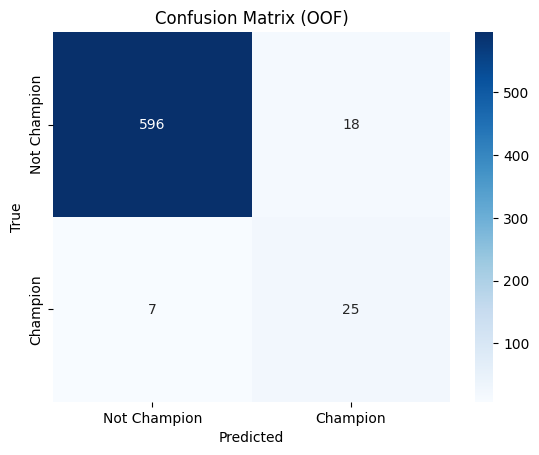

In [11]:
# Overall evaluation
print("\nClassification report (OOF predictions):")
print(classification_report(oof_true, (oof_probs > 0.5).astype(int)))

cm = confusion_matrix(oof_true, (oof_probs > 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Champion", "Champion"],
            yticklabels=["Not Champion", "Champion"])
plt.title("Confusion Matrix (OOF)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

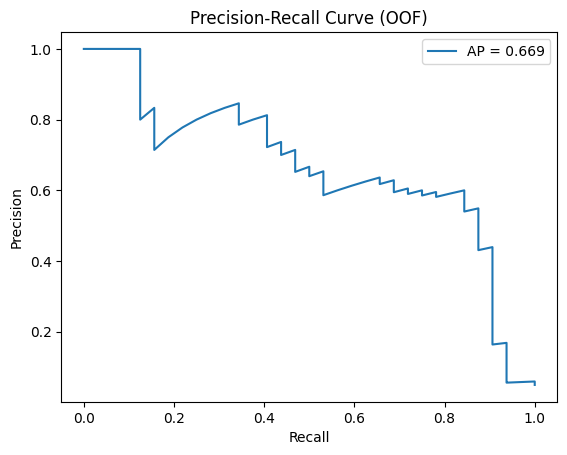

In [12]:
# Precision-Recall curve
prec, rec, _ = precision_recall_curve(oof_true, oof_probs)
plt.plot(rec, prec, label=f"AP = {average_precision_score(oof_true, oof_probs):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (OOF)")
plt.legend()
plt.show()

In [15]:
# Train final model on all data
sm = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = sm.fit_resample(X, y)

scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)

final_clf = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=RANDOM_STATE
)
final_clf.fit(X_res_scaled, y_res)

final_calib = CalibratedClassifierCV(estimator=final_clf, method='sigmoid', cv=5)
final_calib.fit(X_res_scaled, y_res)

# Wrap in a pipeline for easy predictions
class PipelineWrapper:
    def __init__(self, scaler, clf, features):
        self.scaler = scaler
        self.clf = clf
        self.features = features

    def predict_proba(self, X_df):
        Xf = X_df[self.features].copy()
        Xs = self.scaler.transform(Xf)
        return self.clf.predict_proba(Xs)

    def predict(self, X_df):
        return np.argmax(self.predict_proba(X_df), axis=1)

pipeline = PipelineWrapper(scaler=scaler, clf=final_calib, features=FEATURES)

In [16]:
# Save model
dump(pipeline, "model_pipeline.joblib")
print("Saved model pipeline to model_pipeline.joblib")

Saved model pipeline to model_pipeline.joblib


In [17]:
# Test prediction
example_row = {
    'played': 20, 'won': 12, 'drawn': 5, 'lost': 3,
    'gf': 38, 'ga': 18, 'gd': 20
}
example_df = pd.DataFrame([example_row])
example_df = add_derived_features(example_df)
prob = pipeline.predict_proba(example_df)[0, 1]
print(f"\nExample team champion probability: {prob:.3%}")



Example team champion probability: 50.983%
